## Mounting Gdrive

In [ ]:
# Mounting Gdrive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Unzipping the tiny-imagenet dataset

You can download the tiny-imagenet dataset in the below link:

https://drive.google.com/file/d/1paHGBBjPvLXugTbDGe1DKJe0Mki_wVmb/view?usp=share_link

In [ ]:
!unzip /content/gdrive/MyDrive/Masters/Deep_learning_project/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

## Data Preparation

In [ ]:
import os 
import shutil
import random
import pandas as pd 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
import glob

cover_train_paths = glob.glob('/content/tiny-imagenet-200/train/n01443537/images/*')
secret_train_paths = glob.glob('/content/tiny-imagenet-200/train/n01629819/images/*')

In [ ]:
from PIL import Image

cover_images = []
secret_images = []

for cover, sc1 in zip(sorted(cover_train_paths),sorted(secret_train_paths)):
  cov = Image.open(cover)
  s1 = Image.open(sc1)
  cover_images.append(cov)
  secret_images.append(s1)

In [ ]:
len(cover_images),len(secret_images)

(500, 500)

In [ ]:
import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Normalize the images
def normalize_images(images):
    return np.array([np.array(img) / 255.0 for img in images])


# Split the dataset into training and validation sets
cover_images = normalize_images(cover_images)
secret_images = normalize_images(secret_images)

X_cover_train, X_cover_val, X_secret_train, X_secret_val = train_test_split(cover_images, secret_images, test_size=0.2, random_state=42)

# Create TensorFlow Dataset objects
BATCH_SIZE = 32
BUFFER_SIZE = 100

def create_dataset(X_cover, X_secret, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(((X_cover, X_secret), (X_cover, X_secret)))
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_cover_train, X_secret_train, BATCH_SIZE, BUFFER_SIZE)
val_dataset = create_dataset(X_cover_val, X_secret_val, BATCH_SIZE, BUFFER_SIZE)


## Model Building Encoder and Decoder

### Encoder architecture

In [ ]:
import tensorflow as tf

def prep_network_1(secret_image):
    conv1 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), strides=1, padding='same')
    conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=1, padding='same')
    conv3 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), strides=1, padding='same')

    conv4 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), strides=1, padding='same')
    conv5 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=1, padding='same')
    conv6 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), strides=1, padding='same')

    output_1 = tf.nn.relu(conv1(secret_image))
    output_2 = tf.nn.relu(conv2(secret_image))
    output_3 = tf.nn.relu(conv3(secret_image))

    concatenated_image = tf.concat([output_1, output_2, output_3], axis=3)
    
    output_4 = tf.nn.relu(conv4(concatenated_image))
    output_5 = tf.nn.relu(conv5(concatenated_image))
    output_6 = tf.nn.relu(conv6(concatenated_image))

    final_concat_image = tf.concat([output_4, output_5, output_6], axis=3)
    return final_concat_image


In [ ]:
def hiding_network(secret_image_1, cover_image):
    conv1 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv3 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), strides=(1, 1), padding='same')

    conv4 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv5 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv6 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), strides=(1, 1), padding='same')

    conv7 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv8 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv9 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), strides=(1, 1), padding='same')

    conv10 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv11 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv12 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), strides=(1, 1), padding='same')

    conv13 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv14 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), padding='same')
    conv15 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), strides=(1, 1), padding='same')

    final_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same')

    concatenated_secrets = tf.concat([cover_image, secret_image_1], axis=3)

    output_1 = tf.nn.relu(conv1(concatenated_secrets))
    output_2 = tf.nn.relu(conv2(concatenated_secrets))
    output_3 = tf.nn.relu(conv3(concatenated_secrets))
    concat_1 = tf.concat([output_1, output_2, output_3], axis=3)

    output_4 = tf.nn.relu(conv4(concat_1))
    output_5 = tf.nn.relu(conv5(concat_1))
    output_6 = tf.nn.relu(conv6(concat_1))
    concat_2 = tf.concat([output_4, output_5, output_6], axis=3)

    output_7 = tf.nn.relu(conv7(concat_2))
    output_8 = tf.nn.relu(conv8(concat_2))
    output_9 = tf.nn.relu(conv9(concat_2))
    concat_3 = tf.concat([output_7, output_8, output_9], axis=3)

    output_10 = tf.nn.relu(conv10(concat_3))
    output_11 = tf.nn.relu(conv11(concat_3))
    output_12 = tf.nn.relu(conv12(concat_3))
    concat_4 = tf.concat([output_10, output_11, output_12], axis=3)

    output_13 = tf.nn.relu(conv13(concat_4))
    output_14 = tf.nn.relu(conv14(concat_4))
    output_15 = tf.nn.relu(conv15(concat_4))
    concat_5 = tf.concat([output_13, output_14, output_15], axis=3)

    output_converted_image = tf.nn.relu(final_layer(concat_5))

    return output_converted_image

In [ ]:
def encoder(secret_image, cover_image):
    # Process the secret image using the preparation network
    prepped_secret_image = prep_network_1(secret_image)

    # Combine the prepped secret image and cover image using the hiding network
    encoded_image = hiding_network(prepped_secret_image, cover_image)

    return encoded_image


In [ ]:
# Define the input tensors for secret and cover images
secret_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name='secret_image_input')
cover_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name='cover_image_input')

# Use the encoder function to create the encoded image
encoded_image_output = encoder(secret_image_input, cover_image_input)

# Create the encoder model
encoder_model = tf.keras.Model(inputs=[secret_image_input, cover_image_input], outputs=encoded_image_output, name='encoder_model')

# Print a summary of the model
encoder_model.summary()


Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 secret_image_input (InputLayer  [(None, 64, 64, 3)]  0          []                               
 )                                                                                                
                                                                                                  
 conv2d_78 (Conv2D)             (None, 64, 64, 50)   1400        ['secret_image_input[0][0]']     
                                                                                                  
 conv2d_79 (Conv2D)             (None, 64, 64, 10)   280         ['secret_image_input[0][0]']     
                                                                                                  
 conv2d_80 (Conv2D)             (None, 64, 64, 5)    380         ['secret_image_input[

### Decoder architecture

In [ ]:
import tensorflow as tf

def reveal_network1(hidden_image):
    conv1 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), strides=1, padding='same')
    conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=1, padding='same')
    conv3 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), strides=1, padding='same')

    conv4 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), strides=1, padding='same')
    conv5 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=1, padding='same')
    conv6 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), strides=1, padding='same')

    conv7 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), strides=1, padding='same')
    conv8 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=1, padding='same')
    conv9 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), strides=1, padding='same')

    conv10 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), strides=1, padding='same')
    conv11 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=1, padding='same')
    conv12 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), strides=1, padding='same')

    conv13 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), strides=1, padding='same')
    conv14 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=1, padding='same')
    conv15 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), strides=1, padding='same')

    final_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')

    output_1 = tf.nn.relu(conv1(hidden_image))
    output_2 = tf.nn.relu(conv2(hidden_image))
    output_3 = tf.nn.relu(conv3(hidden_image))
    concat_1 = tf.concat([output_1, output_2, output_3], axis=3)

    output_4 = tf.nn.relu(conv4(concat_1))
    output_5 = tf.nn.relu(conv5(concat_1))
    output_6 = tf.nn.relu(conv6(concat_1))
    concat_2 = tf.concat([output_4, output_5, output_6], axis=3)

    output_7 = tf.nn.relu(conv7(concat_2))
    output_8 = tf.nn.relu(conv8(concat_2))
    output_9 = tf.nn.relu(conv9(concat_2))
    concat_3 = tf.concat([output_7, output_8, output_9], axis=3)

    output_10 = tf.nn.relu(conv10(concat_3))
    output_11 = tf.nn.relu(conv11(concat_3))
    output_12 = tf.nn.relu(conv12(concat_3))
    concat_4 = tf.concat([output_10, output_11, output_12], axis=3)

    output_13 = tf.nn.relu(conv13(concat_4))
    output_14 = tf.nn.relu(conv14(concat_4))
    output_15 = tf.nn.relu(conv15(concat_4))
    concat_5 = tf.concat([output_13, output_14, output_15], axis=3)

    output_revealed_image = tf.nn.relu(final_layer(concat_5))

    return output_revealed_image


In [ ]:
def decoder(hidden_image):
  return reveal_network1(hidden_image)

In [ ]:
# Define the input layer for the hidden image
hidden_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name="hidden_image_input")

# Use the reveal network to create the revealed image
revealed_image_output = reveal_network1(hidden_image_input)

# Create the decoder model
decoder_model = tf.keras.Model(inputs=hidden_image_input, outputs=revealed_image_output, name="decoder_model")

# Display the model summary
decoder_model.summary()


Model: "decoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 hidden_image_input (InputLayer  [(None, 64, 64, 3)]  0          []                               
 )                                                                                                
                                                                                                  
 conv2d_116 (Conv2D)            (None, 64, 64, 50)   1400        ['hidden_image_input[0][0]']     
                                                                                                  
 conv2d_117 (Conv2D)            (None, 64, 64, 10)   280         ['hidden_image_input[0][0]']     
                                                                                                  
 conv2d_118 (Conv2D)            (None, 64, 64, 5)    380         ['hidden_image_input[

### Encoder-Decoder architecture combined

In [ ]:


# Define input layers for secret and cover images for the combined model
combined_secret_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name="combined_secret_image_input")
combined_cover_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name="combined_cover_image_input")

# Use the encoder model to create the encoded (hidden) image
combined_encoded_image_output = encoder_model([combined_secret_image_input, combined_cover_image_input])

# Use the decoder model to create the revealed (decoded) image from the encoded image
combined_revealed_image_output = decoder_model(combined_encoded_image_output)

# Create the combined model
combined_model = tf.keras.Model(inputs=[combined_secret_image_input, combined_cover_image_input], outputs=[combined_encoded_image_output, combined_revealed_image_output], name="combined_model")

# Display the model summary
combined_model.summary()


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 combined_secret_image_input (I  [(None, 64, 64, 3)]  0          []                               
 nputLayer)                                                                                       
                                                                                                  
 combined_cover_image_input (In  [(None, 64, 64, 3)]  0          []                               
 putLayer)                                                                                        
                                                                                                  
 encoder_model (Functional)     (None, 64, 64, 3)    265553      ['combined_secret_image_input[0][
                                                                 0]',                

### Model Training

In [ ]:
# Loss function and model compilation
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

combined_model.compile(optimizer='adam', loss=[custom_loss, custom_loss], loss_weights=[0.5, 0.5])

# Train the model
EPOCHS = 80
combined_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Epoch 1/80
13/13 [==============================] - 30s 387ms/step - loss: 0.1427 - encoder_model_loss: 0.1194 - decoder_model_loss: 0.1660 - val_loss: 0.0625 - val_encoder_model_loss: 0.0560 - val_decoder_model_loss: 0.0690
Epoch 2/80
13/13 [==============================] - 3s 221ms/step - loss: 0.0513 - encoder_model_loss: 0.0509 - decoder_model_loss: 0.0518 - val_loss: 0.0389 - val_encoder_model_loss: 0.0382 - val_decoder_model_loss: 0.0396
Epoch 3/80
13/13 [==============================] - 3s 209ms/step - loss: 0.0365 - encoder_model_loss: 0.0325 - decoder_model_loss: 0.0406 - val_loss: 0.0383 - val_encoder_model_loss: 0.0320 - val_decoder_model_loss: 0.0446
Epoch 4/80
13/13 [==============================] - 3s 207ms/step - loss: 0.0309 - encoder_model_loss: 0.0261 - decoder_model_loss: 0.0358 - val_loss: 0.0289 - val_encoder_model_loss: 0.0264 - val_decoder_model_loss: 0.0314
Epoch 5/80
13/13 [==============================] - 3s 208ms/step - loss: 0.0269 - encoder_model_loss: 

## Saving Model

In [ ]:
%cd /content/gdrive/MyDrive/Masters/Deep_learning_project

/content/gdrive/MyDrive/Masters/Deep_learning_project


In [ ]:
# combined_model.save('combined_model.h5')

In [ ]:
# encoder_model.save('encoder_model.h5')

In [ ]:
# decoder_model.save('decoder_model.h5')

## Visualizing results

1/1 [==============================] - 0s 33ms/step


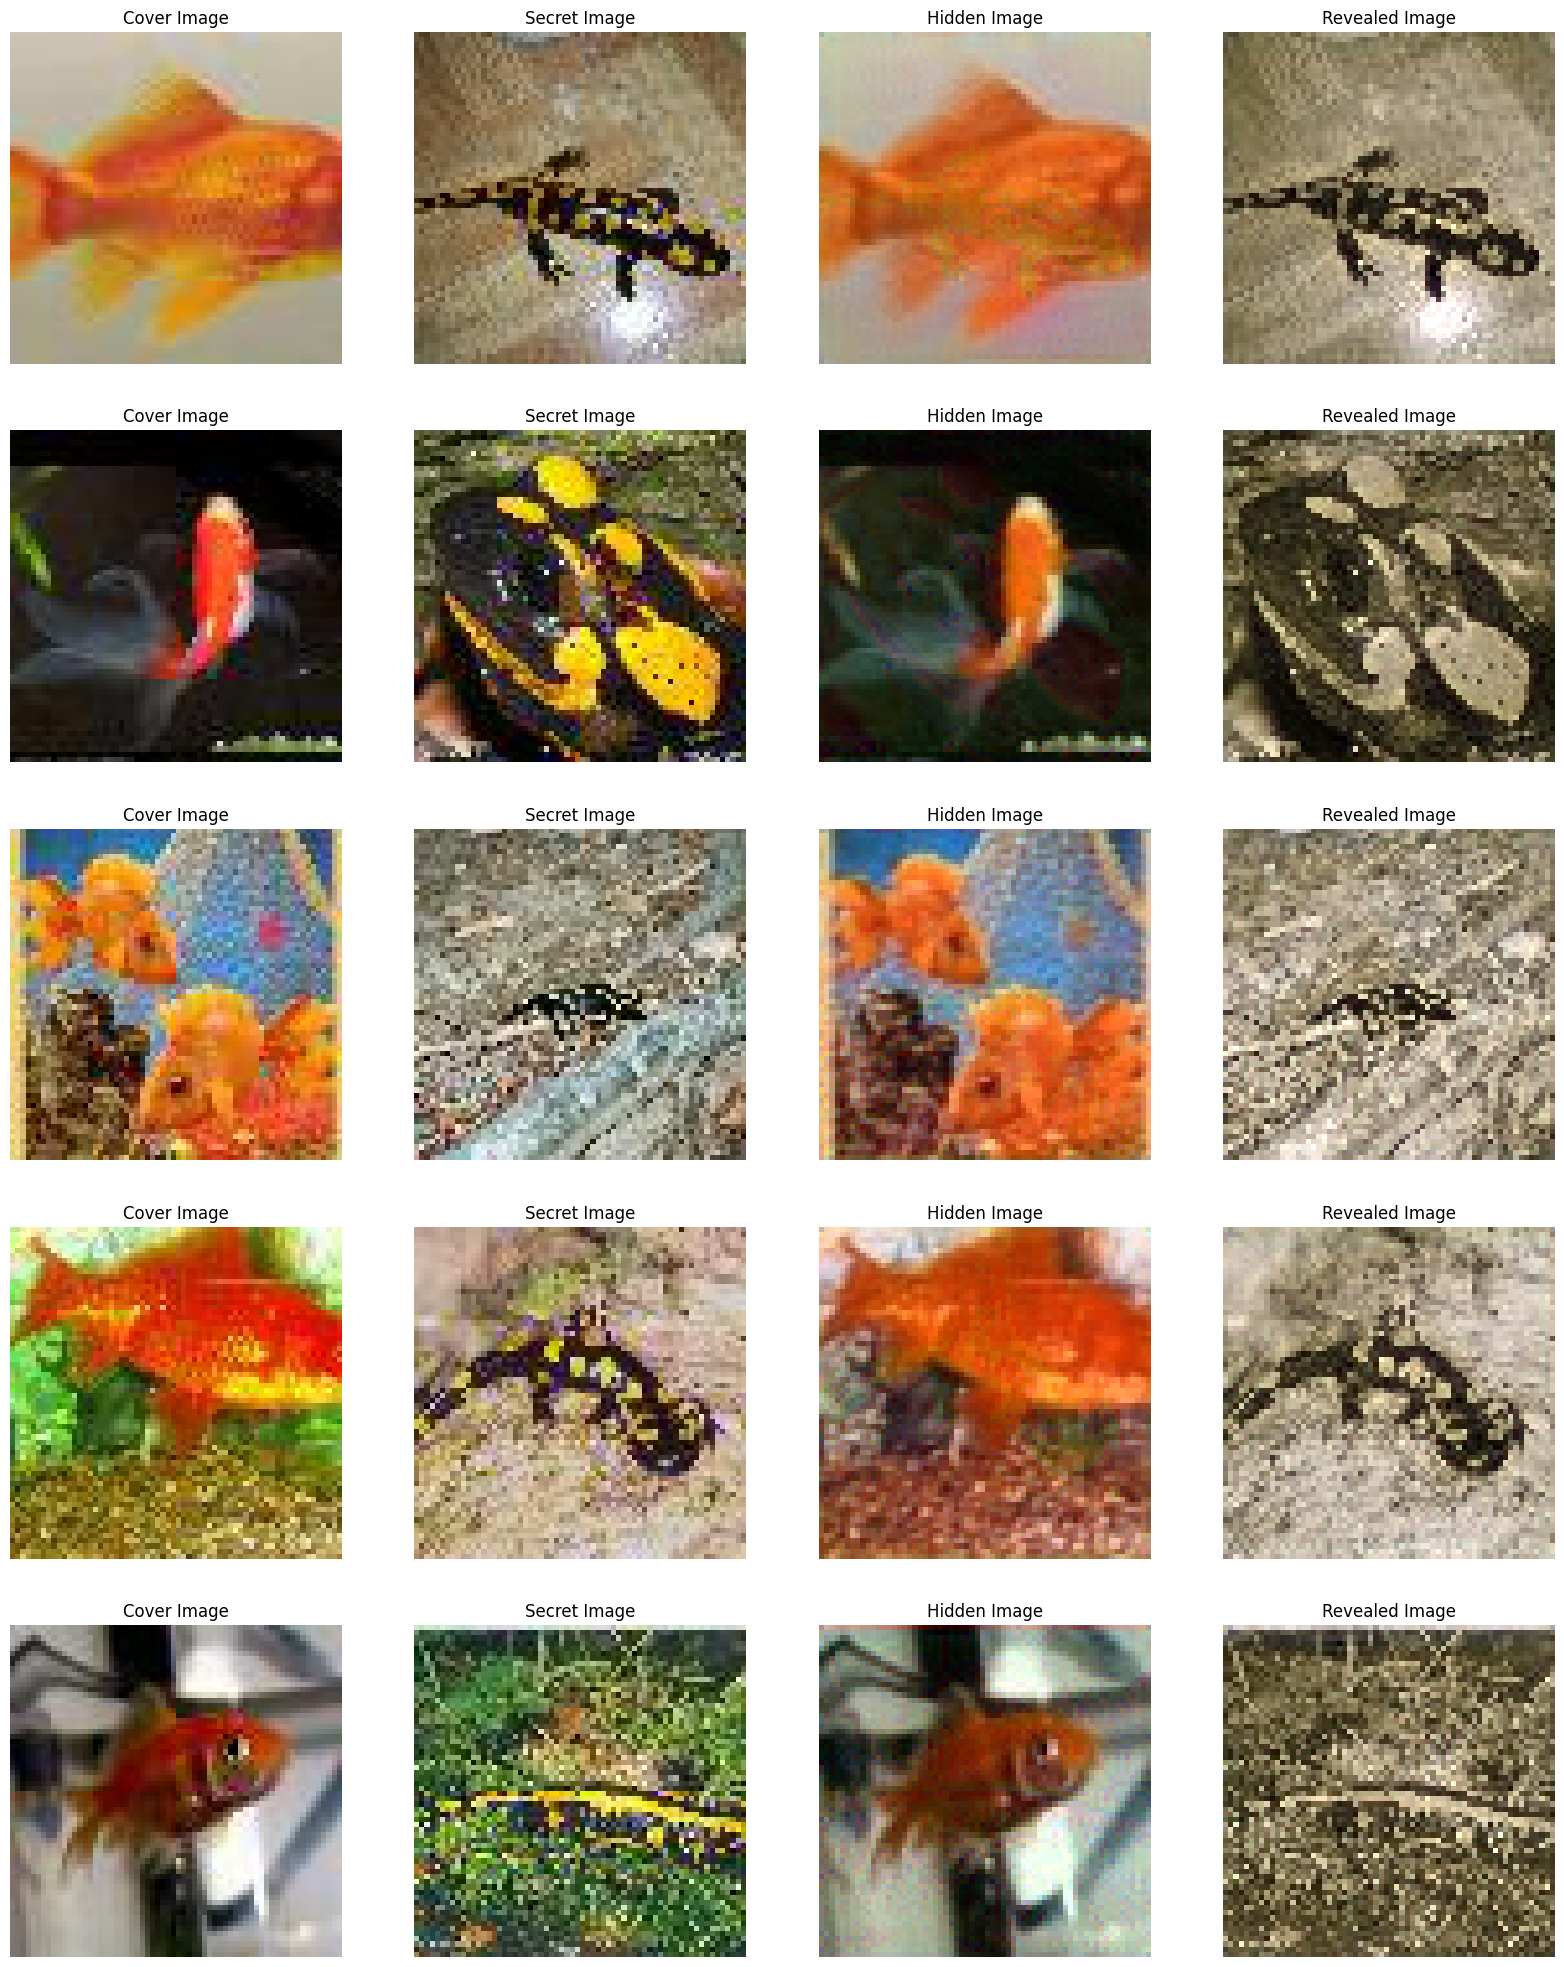

In [ ]:
import matplotlib.pyplot as plt

# Take one batch of data from the val_dataset
cover_batch, secret_batch = next(iter(val_dataset))[0]

# Hide the secret images within the cover images using the hiding network
hidden_batch = encoder_model.predict([cover_batch, secret_batch])

# Extract the secret images from the hidden images using the revealing network
revealed_batch = decoder_model.predict(hidden_batch)

# Display a few examples
num_examples = 5

fig, axes = plt.subplots(num_examples, 4, figsize=(20, num_examples * 5))

for i in range(num_examples):
    axes[i, 0].imshow(cover_batch[i])
    axes[i, 0].set_title("Cover Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(secret_batch[i])
    axes[i, 1].set_title("Secret Image")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(hidden_batch[i])
    axes[i, 2].set_title("Hidden Image")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(revealed_batch[i])
    axes[i, 3].set_title("Revealed Image")
    axes[i, 3].axis("off")
plt.savefig('img_img_stego_1.jpg')
plt.show()

## Calculating Structural similarity Index value for the results

In [ ]:
import tensorflow as tf

def calculate_ssim(cover_image, stego_image, max_val=1.0):
    """
    Calculate the Structural Similarity Index (SSIM) between two images.

    :param cover_image: The cover image, a TensorFlow tensor with shape (batch_size, height, width, channels)
    :param stego_image: The stego (hidden) image, a TensorFlow tensor with shape (batch_size, height, width, channels)
    :param max_val: The maximum pixel value, default to 1.0 for normalized images
    :return: The average SSIM value for the batch of images
    """

    ssim_value = tf.image.ssim(cover_image, stego_image, max_val=max_val)

    # Calculate the average SSIM value for the batch of images
    average_ssim = tf.reduce_mean(ssim_value)

    return average_ssim

In [ ]:
for index in range(5):
  original_img = cover_batch[index]
  secret_img = secret_batch[index]
  hidden_img = hidden_batch[index]
  reveal_img = revealed_batch[index]

  # Expand the dimensions of the images to create a batch with a single image
  original_img = tf.expand_dims(original_img, axis=0)
  secret_img = tf.expand_dims(secret_img, axis=0)
  hidden_img = tf.expand_dims(hidden_img, axis=0)
  reveal_img = tf.expand_dims(reveal_img, axis=0)

  # Convert tensors to the same data type
  original_img = tf.cast(original_img, dtype=tf.float32)
  secret_img = tf.cast(secret_img, dtype=tf.float32)
  hidden_img = tf.cast(hidden_img, dtype=tf.float32)
  reveal_img = tf.cast(reveal_img, dtype=tf.float32)

  ssim_cover_hidden = calculate_ssim(original_img,hidden_img)
  ssim_secret_reveal = calculate_ssim(secret_img,reveal_img)

  print(f'ssim between cover img{index} and hidden img {index} using Encoder is :', ssim_cover_hidden)
  print(f'ssim between secret img{index} and reveal img {index} using Decoder is :', ssim_secret_reveal)

ssim between cover img0 and hidden img 0 using Encoder is : tf.Tensor(0.8041449, shape=(), dtype=float32)
ssim between secret img0 and reveal img 0 using Decoder is : tf.Tensor(0.954123, shape=(), dtype=float32)
ssim between cover img1 and hidden img 1 using Encoder is : tf.Tensor(0.78482467, shape=(), dtype=float32)
ssim between secret img1 and reveal img 1 using Decoder is : tf.Tensor(0.8131516, shape=(), dtype=float32)
ssim between cover img2 and hidden img 2 using Encoder is : tf.Tensor(0.8086726, shape=(), dtype=float32)
ssim between secret img2 and reveal img 2 using Decoder is : tf.Tensor(0.95921963, shape=(), dtype=float32)
ssim between cover img3 and hidden img 3 using Encoder is : tf.Tensor(0.7254166, shape=(), dtype=float32)
ssim between secret img3 and reveal img 3 using Decoder is : tf.Tensor(0.92742413, shape=(), dtype=float32)
ssim between cover img4 and hidden img 4 using Encoder is : tf.Tensor(0.8878558, shape=(), dtype=float32)
ssim between secret img4 and reveal img 

## Calculating SSIM between Original and LSB Stego Images

In [ ]:
import cv2
import numpy as np

def hide_in_LSB(cover_image, secret_image, num_bits=1):
    if cover_image.shape != secret_image.shape:
        raise ValueError("Cover and secret images must have the same dimensions")

    # Ensure the number of bits is within the allowed range
    num_bits = tf.clip_by_value(num_bits, 1, 8)

    # Convert images to uint8
    cover_image = tf.cast(cover_image * 255, tf.uint8)
    secret_image = tf.cast(secret_image * 255, tf.uint8)

    # Hide the secret_image into the LSBs of the cover_image
    mask_cover = tf.cast(255 - (2 ** num_bits - 1), tf.uint8)
    mask_secret = tf.cast(255 - mask_cover, tf.uint8)

    cover_image = tf.bitwise.bitwise_and(cover_image, mask_cover)
    secret_image = tf.bitwise.right_shift(secret_image, tf.cast(8 - num_bits, tf.uint8))
    secret_image = tf.bitwise.bitwise_and(secret_image, mask_secret)

    stego_image = tf.bitwise.bitwise_or(cover_image, secret_image)
    
    # Convert back to float
    stego_image = tf.cast(stego_image, tf.float32) / 255.0
    
    return stego_image

In [ ]:
for index in range(5):
  original_img = cover_batch[index]
  secret_img = secret_batch[index]
  hidden_img = hide_in_LSB(original_img,secret_img)

  # Expand the dimensions of the images to create a batch with a single image
  original_img = tf.expand_dims(original_img, axis=0)
  secret_img = tf.expand_dims(secret_img, axis=0)
  hidden_img = tf.expand_dims(hidden_img, axis=0)

  # Convert tensors to the same data type
  original_img = tf.cast(original_img, dtype=tf.float32)
  secret_img = tf.cast(secret_img, dtype=tf.float32)
  hidden_img = tf.cast(hidden_img, dtype=tf.float32)

  ssim_cover_hidden = calculate_ssim(original_img,hidden_img)

  print(f'ssim between cover img{index} and hidden img {index} using LSB is :', ssim_cover_hidden)

ssim between cover img0 and hidden img 0 using LSB is : tf.Tensor(0.9981145, shape=(), dtype=float32)
ssim between cover img1 and hidden img 1 using LSB is : tf.Tensor(0.9980332, shape=(), dtype=float32)
ssim between cover img2 and hidden img 2 using LSB is : tf.Tensor(0.9995907, shape=(), dtype=float32)
ssim between cover img3 and hidden img 3 using LSB is : tf.Tensor(0.9993879, shape=(), dtype=float32)
ssim between cover img4 and hidden img 4 using LSB is : tf.Tensor(0.999315, shape=(), dtype=float32)
